In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import itertools
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
import pylab 
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from pandas import to_datetime

def addZero(symbol):#该函数负责将股票代码前面的0补全
    if(len(symbol)==1):
        return "00000"+symbol
    if(len(symbol)==2):
        return "0000"+symbol
    if(len(symbol)==3):
        return "000"+symbol
    if(len(symbol)==4):
        return "00"+symbol
    if(len(symbol)==5):
        return "0"+symbol
    if(len(symbol)==6):
        return symbol
    
def plotsymbol(symbol,x,y):#画出代码为symbol的股票的图，x可以为日期，y可以为营收，利润等
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol][x],Income.loc[Income['TICKER_SYMBOL']==symbol][y])
    
def isContinuous(t):
    if (t.dtype!='datetime64[ns]'):
        raise "t must be 'datetime64[ns]'"
        return
    if t.size==pd.date_range(t.min(),t.max(),freq='Q').size:
        return True
    else:
        return False

In [224]:
###读取数据
Income=pd.read_excel("C:/FDDC_financial_data/FDDC_financial_data/Financial Data/Income Statement.xls",sheet_name="General Business")

In [225]:
###数据预处理阶段
#将股票代码变为字符串型
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].astype(str)
#股票代码加0
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].apply(addZero)
#将END_DATE转变为日期类型
Income['END_DATE']=pd.to_datetime(Income['END_DATE'],format='%Y-%m-%d')

In [226]:
###去除多余列，由于是时间序列分析，仅分析时间、股票代码、营收即可
#保留3列
Income=Income.loc[:,['END_DATE','TICKER_SYMBOL','REVENUE']]
#按报告截止日和股东代码排序
Income=Income.sort_values(by=['END_DATE', 'TICKER_SYMBOL'])

In [227]:
#看看有没有重复行
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

97281

In [228]:
#观察某个重复值的样本，可以发现第二次重复的值有了新的值，可能是报告期补充了新的数据
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,END_DATE,TICKER_SYMBOL,REVENUE
940,2009-03-31,000002,8.164319e+09
1106,2009-03-31,000002,8.164319e+09


In [229]:
#删除重复行
Income=Income.drop_duplicates(['END_DATE','TICKER_SYMBOL'],keep='last')
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有110852行，3列


In [230]:
#观察同一只股票的同一期，是否还有重复值
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

0

In [231]:
###形成训练集
#改变index为timeindex,以便后续时间序列分析，并去除end_date列
Income.index=Income['END_DATE']
Income=Income.drop('END_DATE',axis=1)
#增加训练集
train=Income
Income=[]
#2008前由于缺报告比较多，所以剔除
train=train['2008':]

In [232]:
train.shape

(110087, 2)

In [233]:
train.head()

,TICKER_SYMBOL,REVENUE
END_DATE,,
2008-03-31,000002,6.400436e+09
2008-03-31,000004,8.841862e+06
2008-03-31,000005,1.847533e+07
2008-03-31,000006,7.035197e+08
2008-03-31,000007,4.336484e+07


In [234]:
###看有哪些股票时间序列不连续，对于时间序列不连续的股票，不能直接用时间序列分析
symbol_discontinuous=[]
symbol_continuous=[]
for symbol in train['TICKER_SYMBOL'].unique():
    if (isContinuous(train[train['TICKER_SYMBOL']==symbol].index)==False):
        symbol_discontinuous.append(symbol)
        print ("%s的时间序列不连续"%symbol)
    else:
        symbol_continuous.append(symbol)

000627的时间序列不连续
000693的时间序列不连续
000722的时间序列不连续
300077的时间序列不连续
600094的时间序列不连续
601668的时间序列不连续
300444的时间序列不连续
600050的时间序列不连续
601018的时间序列不连续
002445的时间序列不连续
002446的时间序列不连续
002448的时间序列不连续
002450的时间序列不连续
002451的时间序列不连续
002452的时间序列不连续
002453的时间序列不连续
002455的时间序列不连续
002457的时间序列不连续
002458的时间序列不连续
002459的时间序列不连续
002460的时间序列不连续
002461的时间序列不连续
002462的时间序列不连续
002463的时间序列不连续
002464的时间序列不连续
002465的时间序列不连续
002466的时间序列不连续
002467的时间序列不连续
002468的时间序列不连续
002469的时间序列不连续
002470的时间序列不连续
002471的时间序列不连续
002472的时间序列不连续
002473的时间序列不连续
002474的时间序列不连续
002475的时间序列不连续
002476的时间序列不连续
002477的时间序列不连续
002478的时间序列不连续
002479的时间序列不连续
002480的时间序列不连续
002481的时间序列不连续
002482的时间序列不连续
002483的时间序列不连续
002484的时间序列不连续
002485的时间序列不连续
002486的时间序列不连续
002487的时间序列不连续
002488的时间序列不连续
002490的时间序列不连续
002491的时间序列不连续
002492的时间序列不连续
002493的时间序列不连续
002494的时间序列不连续
002495的时间序列不连续
002496的时间序列不连续
002497的时间序列不连续
002498的时间序列不连续
002499的时间序列不连续
002501的时间序列不连续
002502的时间序列不连续
002503的时间序列不连续
002505的时间序列不连续
002506的时间序列不连续
002507的时间序列不连续
002508的时间序列不连续
002509的时间序

601985的时间序列不连续
601992的时间序列不连续
601996的时间序列不连续
603000的时间序列不连续
603001的时间序列不连续
603002的时间序列不连续
603003的时间序列不连续
603123的时间序列不连续
603128的时间序列不连续
603167的时间序列不连续
603197的时间序列不连续
603333的时间序列不连续
603359的时间序列不连续
603599的时间序列不连续
603861的时间序列不连续
603993的时间序列不连续
000333的时间序列不连续
002678的时间序列不连续
002679的时间序列不连续
002680的时间序列不连续
002681的时间序列不连续
002683的时间序列不连续
002684的时间序列不连续
002686的时间序列不连续
002687的时间序列不连续
002689的时间序列不连续
002692的时间序列不连续
002693的时间序列不连续
002694的时间序列不连续
002695的时间序列不连续
002697的时间序列不连续
002698的时间序列不连续
002700的时间序列不连续
002703的时间序列不连续
002710的时间序列不连续
002720的时间序列不连续
002743的时间序列不连续
002746的时间序列不连续
002748的时间序列不连续
002752的时间序列不连续
002756的时间序列不连续
002773的时间序列不连续
002782的时间序列不连续
002792的时间序列不连续
002815的时间序列不连续
002838的时间序列不连续
002843的时间序列不连续
002851的时间序列不连续
002905的时间序列不连续
300322的时间序列不连续
300323的时间序列不连续
300328的时间序列不连续
300332的时间序列不连续
300333的时间序列不连续
300334的时间序列不连续
300335的时间序列不连续
300336的时间序列不连续
300338的时间序列不连续
300341的时间序列不连续
300342的时间序列不连续
300347的时间序列不连续
300348的时间序列不连续
300349的时间序列不连续
300351的时间序列不连续
300352的时间序列不连续
300354的时间序列不连续
300355的时间序

300588的时间序列不连续
300589的时间序列不连续
300590的时间序列不连续
300591的时间序列不连续
300592的时间序列不连续
300595的时间序列不连续
300596的时间序列不连续
300597的时间序列不连续
300598的时间序列不连续
300599的时间序列不连续
300600的时间序列不连续
300601的时间序列不连续
300602的时间序列不连续
300603的时间序列不连续
300605的时间序列不连续
300606的时间序列不连续
300607的时间序列不连续
300608的时间序列不连续
300609的时间序列不连续
300610的时间序列不连续
300611的时间序列不连续
300612的时间序列不连续
300615的时间序列不连续
300623的时间序列不连续
300631的时间序列不连续
300633的时间序列不连续
600936的时间序列不连续
600996的时间序列不连续
601020的时间序列不连续
601206的时间序列不连续
601212的时间序列不连续
601500的时间序列不连续
601595的时间序列不连续
601811的时间序列不连续
601858的时间序列不连续
601882的时间序列不连续
601966的时间序列不连续
603016的时间序列不连续
603027的时间序列不连续
603028的时间序列不连续
603029的时间序列不连续
603031的时间序列不连续
603032的时间序列不连续
603033的时间序列不连续
603035的时间序列不连续
603036的时间序列不连续
603037的时间序列不连续
603038的时间序列不连续
603039的时间序列不连续
603040的时间序列不连续
603058的时间序列不连续
603060的时间序列不连续
603067的时间序列不连续
603069的时间序列不连续
603089的时间序列不连续
603090的时间序列不连续
603098的时间序列不连续
603101的时间序列不连续
603131的时间序列不连续
603159的时间序列不连续
603160的时间序列不连续
603165的时间序列不连续
603177的时间序列不连续
603178的时间序列不连续
603186的时间序列不连续
603189的时间序列不连续
603203的时间序

In [235]:
Revenue_na=[]
##检测营收是否有空值的
for symbol in train['TICKER_SYMBOL'].unique():
    if train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'].isnull().sum()>0:
        Revenue_na.append(symbol)
print (Revenue_na)

['600145', '600149', '600421', '600738', '900957']


In [236]:
#看看营收为空的行有多少（只有9行，无需进行特殊处理）
train.isnull().sum()

TICKER_SYMBOL    0
REVENUE          9
dtype: int64

In [237]:
#看一下某一只不连续时间序列的股票
train[train['TICKER_SYMBOL']=='603813']

,TICKER_SYMBOL,REVENUE
END_DATE,,
2014-12-31,603813,2.927711e+08
2015-12-31,603813,2.930216e+08
2016-09-30,603813,2.401592e+08
2016-12-31,603813,3.375656e+08
2017-03-31,603813,8.943773e+07
2017-06-30,603813,1.832392e+08
2017-09-30,603813,2.832332e+08
2017-12-31,603813,3.925134e+08
2018-03-31,603813,1.174657e+08


In [238]:
#上市公司股东代码数
train['TICKER_SYMBOL'].unique().shape

(3495,)

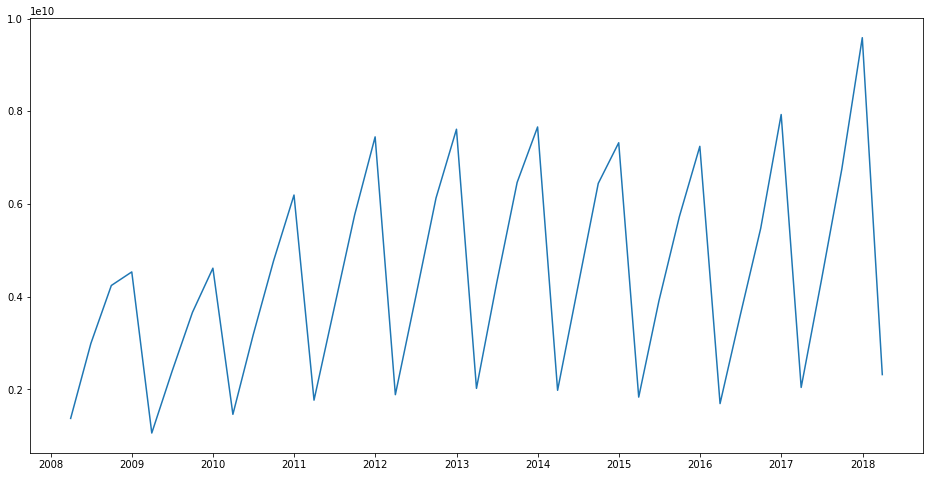

In [239]:
###全市场营收平均值的时间序列图
fig = plt.figure(figsize=(16,8))
plt.plot(train['REVENUE'].groupby(train.index).mean())

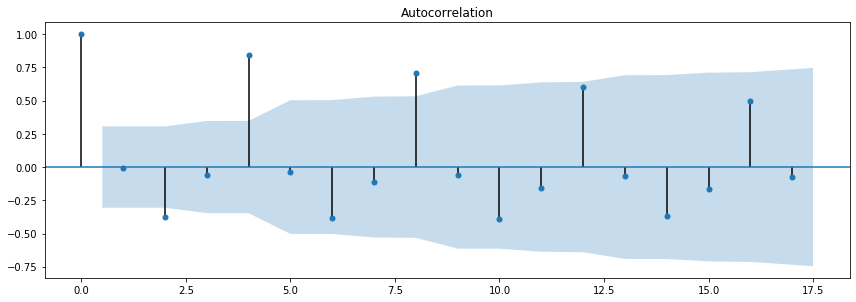

In [240]:
#全市场营收平均值的acf值
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(train['REVENUE'].groupby(train.index).mean(),ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

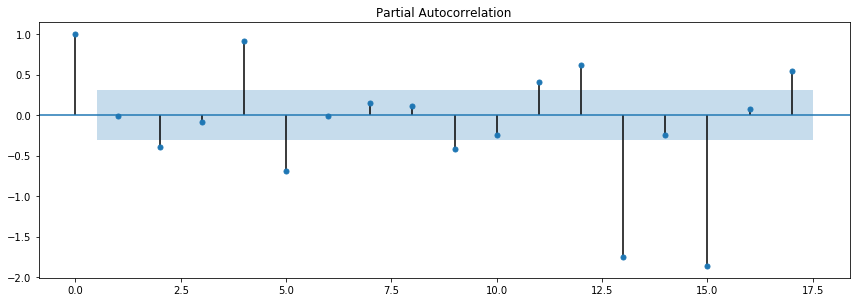

In [241]:
#全市场营收平均值的pacf值
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_pacf(train['REVENUE'].groupby(train.index).mean(),ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [242]:
###先预测包含最近两个完整年，且时间序列连续的数据的公司，这些公司数据质量好，可以用自身AR进行训练
#股价预测dataframe叫predict_each_stock
predict_each_stock=pd.DataFrame(columns=['TICKER_SYMBOL','REVENUE'])
#方法一：AR模型
#for symbol in symbol_continuous:
#    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE']
#    #选取包含2018年一季度的
#    if ((temp.index[-1]==pd.to_datetime('2018-03-31',format='%Y-%m-%d'))):
#        #AR模型
#        try:
#            model = AR(temp)
#            results_AR = model.fit(maxlag=8)
#            predict_value = results_AR.predict(len(temp),len(temp))
#            predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol},ignore_index=True)
#        except:
#            continue
#方法二：ARIMA模型（季节模型）
predict_each_stock=pd.DataFrame(columns=['TICKER_SYMBOL','REVENUE'])
for symbol in symbol_continuous:
    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE']
    p=q=[0,1,2]
    d=[0,1]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]
    aic_min=10e5
    result_order=result_seasonal_order=results=[]
    #选取包含2018年一季度的
    if ((temp.index[-1]==pd.to_datetime('2018-03-31',format='%Y-%m-%d'))):
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(temp,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                    results = mod.fit()
                    if results.aic<aic_min:
                        aic_min=results.aic
                        result_order=param
                        result_seasonal_order=param_seasonal
                    #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                except:
                    continue
        try:
            mod=SARIMAX(temp,order=result_order,seasonal_order=result_seasonal_order)
            results=mod.fit()
            predict_value=results.predict(len(temp),len(temp))
            predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol},ignore_index=True)
        except:
            continue

In [243]:
predict_each_stock

,TICKER_SYMBOL,REVENUE
0,000002,8.250894e+10
1,000004,1.417353e+08
2,000005,2.947339e+08
3,000006,1.438982e+09
4,000007,1.693506e+07
5,000008,5.588382e+08
6,000009,3.691511e+09
7,000010,3.336054e+08
8,000011,5.038005e+08
9,000012,5.564362e+09


In [244]:
#对于报告期不连续的股票，可能是由于中间中断了一段时间，但之后恢复正常，可以看一下最长的连续值，如果最长的连续值大于8（2年）
#且最后一期为2018-03-31也可以预测
max_continuous_years=pd.DataFrame(columns=['TICKER_SYMBOL','MAX_CONTINUOUS_YEARS'])
for symbol in symbol_discontinuous:
    i=20
    while(i>8):
        temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-i:]
        if((isContinuous(temp.index)==True)and(temp.index[-1]==pd.to_datetime('2018-03-31',format='%Y-%m-%d'))):
            max_continuous_years=max_continuous_years.append({'TICKER_SYMBOL':symbol,'MAX_CONTINUOUS_YEARS':i},ignore_index=True)
            i=0#必须要有这一句，确保不再执行while循环，从而执行for循环
            continue
        i=i-4

In [245]:
print(max_continuous_years.sort_values(by='MAX_CONTINUOUS_YEARS',ascending=False))

     TICKER_SYMBOL MAX_CONTINUOUS_YEARS
0           000722                   20
436         300293                   20
438         300295                   20
439         300296                   20
440         300297                   20
441         300298                   20
442         300299                   20
443         300300                   20
444         300301                   20
445         300302                   20
446         300303                   20
447         300304                   20
448         300305                   20
449         300306                   20
450         300307                   20
451         300308                   20
452         300309                   20
453         300310                   20
454         300311                   20
437         300294                   20
435         300292                   20
415         300272                   20
434         300291                   20
417         300274                   20


In [246]:
#对于上述不连续的股票代码，用其最大连续期进行预测
#方法一：AR模型
#for symbol in max_continuous_years['TICKER_SYMBOL']:
#    years=max_continuous_years.loc[max_continuous_years['TICKER_SYMBOL']==symbol]['MAX_CONTINUOUS_YEARS'].values[0]
#    try:
#        #对之前没预测的股票用近2年数据进行AR
#        temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-years:]
#        #如果后期报告时间序列不连续，或最后一个不是18年一季度，则跳过
#        model = AR(temp)
#        results_AR = model.fit(maxlag=8)
#        predict_value = results_AR.predict(len(temp),len(temp))
#        last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE'].values[0]
#        this_year=predict_value.values[0]
#        growth_rate=(this_year-last_year)/last_year
#        predict_each_stock=predict_each_stock.append({'REVENUE':this_year,'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
#    except:
#        continue
#方法二：ARIMA模型
for symbol in max_continuous_years['TICKER_SYMBOL']:
    years=max_continuous_years.loc[max_continuous_years['TICKER_SYMBOL']==symbol]['MAX_CONTINUOUS_YEARS'].values[0]
    #temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-years:]
    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-8:]
    p=q=[0,1,2]
    d=[0,1]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]
    aic_min=10e5
    result_order=result_seasonal_order=results=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(temp,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                if results.aic<aic_min:
                    aic_min=results.aic
                    result_order=param
                    result_seasonal_order=param_seasonal
            except:
                continue
    try:
        mod=SARIMAX(temp,order=result_order,seasonal_order=result_seasonal_order)
        results=mod.fit()
        predict_value=results.predict(len(temp),len(temp))
        predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol},ignore_index=True)
    except:
        continue

In [247]:
predict_each_stock.sort_values(by='REVENUE',ascending=False)
###增加一列，营收增长
for symbol in predict_each_stock['TICKER_SYMBOL']:
    idx=predict_each_stock.loc[predict_each_stock['TICKER_SYMBOL']==symbol].index
    this_year=predict_each_stock.loc[idx,'REVENUE']
    last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']
    growth_rate=(this_year.values[0]-last_year.values[0])/last_year.values[0]
    predict_each_stock.loc[idx,'GROWTH_RATE']=growth_rate

In [248]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
2332,601558,-8.489145e+08,-35.530945
607,002164,-8.670032e+09,-27.223866
310,000809,-2.878475e+07,-4.216586
1720,002408,-1.316783e+10,-3.802139
2503,603518,-2.198033e+09,-3.367180
969,600301,-4.884301e+07,-3.199814
2057,002685,-3.279375e+09,-2.692659
1699,002387,-1.898719e+07,-2.549153
2011,002629,-1.515704e+09,-2.050275
103,000509,-7.654812e+08,-2.048237


In [249]:
###看看上下5%分位数占多少，去掉上下5%分位数
#predict_each_stock=predict_each_stock.loc[(predict_each_stock['GROWTH_RATE']<predict_each_stock['GROWTH_RATE'].quantile(0.95))&(predict_each_stock['GROWTH_RATE']>predict_each_stock['GROWTH_RATE'].quantile(0.05))]

In [250]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,2810.000000
mean,0.196223
std,1.716060
min,-35.530945
25%,-0.011474
50%,0.092978
75%,0.250585
max,52.700069


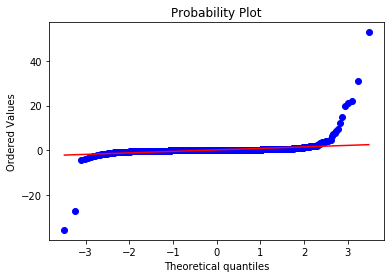

In [251]:
stats.probplot(predict_each_stock['GROWTH_RATE'], dist="norm", plot=pylab)
pylab.show()

In [252]:
#再刷一遍还有多少没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

685

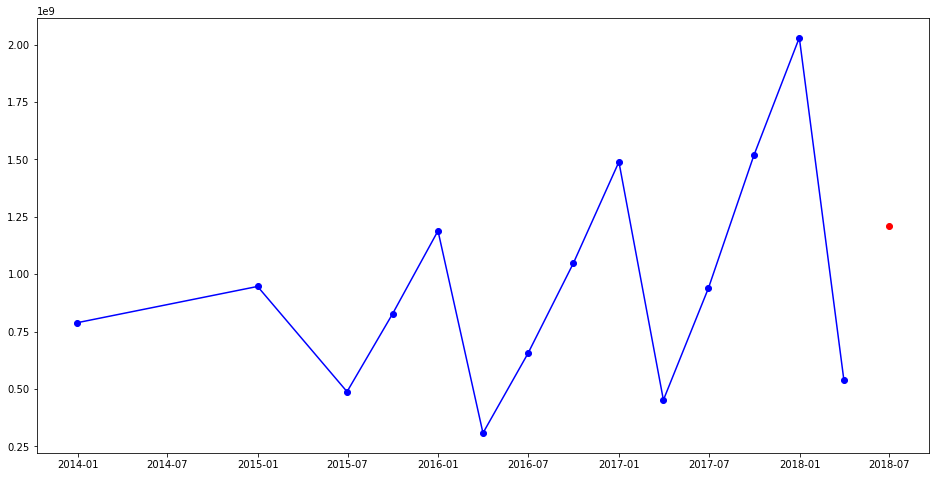

In [253]:
#测试用，看某个个股18年二季度营收与以往的图像
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train.loc[train['TICKER_SYMBOL']=='603986']['REVENUE'],'bo-')
#train.loc[predict_each_stock['TICKER_SYMBOL']=='600462']['REVENUE]
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock.loc[predict_each_stock['TICKER_SYMBOL']=='603986']['REVENUE'],'ro')

In [254]:
train.loc[train['TICKER_SYMBOL']=='603986']

,TICKER_SYMBOL,REVENUE
END_DATE,,
2013-12-31,603986,7.888084e+08
2014-12-31,603986,9.467232e+08
2015-06-30,603986,4.885443e+08
2015-09-30,603986,8.270769e+08
2015-12-31,603986,1.188780e+09
2016-03-31,603986,3.085548e+08
2016-06-30,603986,6.551043e+08
2016-09-30,603986,1.048523e+09
2016-12-31,603986,1.488948e+09


In [255]:
predict_each_stock=predict_each_stock.loc[(predict_each_stock['GROWTH_RATE']<predict_each_stock['GROWTH_RATE'].quantile(0.95))&(predict_each_stock['GROWTH_RATE']>predict_each_stock['GROWTH_RATE'].quantile(0.05))]

In [256]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
2398,300335,5.368709e+08,-0.279499
839,600149,6.718286e+06,-0.274800
2230,300267,1.157224e+09,-0.274558
2284,300326,2.684355e+08,-0.267220
2625,002789,9.671359e+08,-0.266117
820,600125,3.777916e+09,-0.264836
1237,600638,9.234284e+08,-0.262804
2142,300175,1.150174e+08,-0.260425
1278,600685,7.727747e+09,-0.258198
129,000540,7.148568e+09,-0.255531


In [257]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,2528.000000
mean,0.123967
std,0.187895
min,-0.279499
25%,0.000026
50%,0.092978
75%,0.227932
max,0.715684


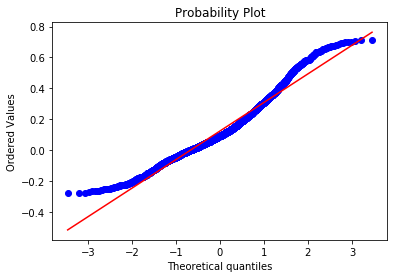

In [258]:
stats.probplot(predict_each_stock['GROWTH_RATE'], dist="norm", plot=pylab)
pylab.show()

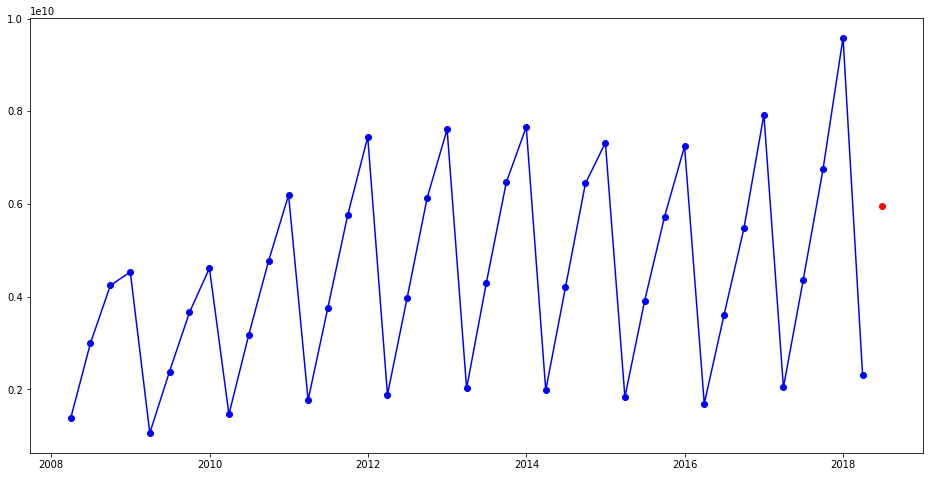

In [259]:
#截至目前全市场营收平均值的时间序列图以及二季度营收的预测值
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).mean(),'bo-')
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock['REVENUE'].mean(),'ro')

In [260]:
train.sort_values(['TICKER_SYMBOL','REVENUE'])

,TICKER_SYMBOL,REVENUE
END_DATE,,
2008-03-31,000002,6.400436e+09
2010-03-31,000002,7.504970e+09
2011-03-31,000002,7.970256e+09
2009-03-31,000002,8.164319e+09
2015-03-31,000002,8.894338e+09
2014-03-31,000002,9.497217e+09
2012-03-31,000002,1.034591e+10
2013-03-31,000002,1.399991e+10
2016-03-31,000002,1.461131e+10


In [261]:
train['TICKER_SYMBOL'].unique().shape

(3495,)

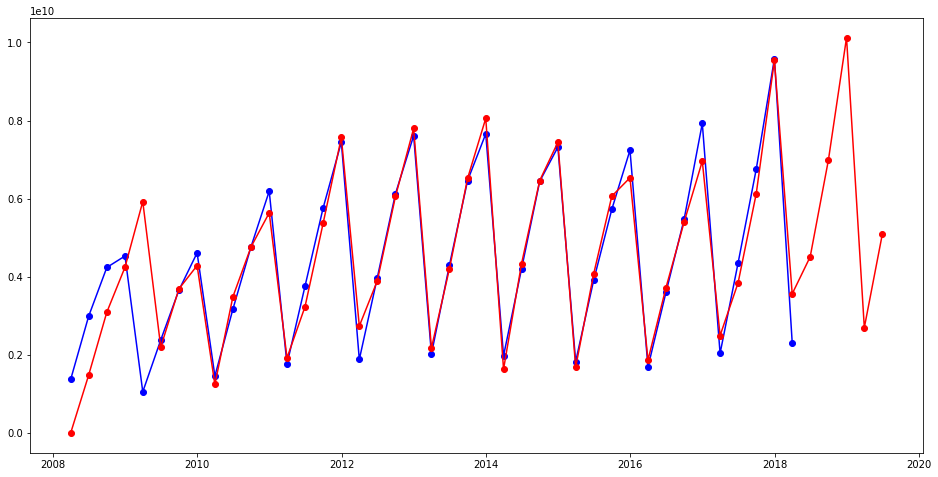

In [262]:
###部分不连续，或有空值的公司，可以采用市场平均值代替其营收，市场平均值采用季节模型
data=train.groupby(train.index).mean()
data=data['2008':]
p=q=[0,1,2]
d=[0,1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]
aic_min=10e5
result_order=result_seasonal_order=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
            if results.aic<aic_min:
                aic_min=results.aic
                result_order=param
                result_seasonal_order=param_seasonal
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#全市场季节模型训练及预测
mod=SARIMAX(data,order=result_order,seasonal_order=result_seasonal_order)
results=mod.fit()
predict=results.predict(0,len(data)+4)
fig = plt.figure(figsize=(16,8))
plt.plot(data,'bo-')
plt.plot(predict,'ro-')

In [263]:
#对于有17年6月数据的，采用ratio，对于没有17年6月数据的，采用ratio1
ratio=(predict['2018-06'].values[0]-predict['2017-06'].values[0])/predict['2017-06'].values[0]
ratio

ratio1=(predict['2018-06'].values[0]-predict['2018-03'].values[0])/predict['2018-03'].values[0]
ratio1
#同比增长

0.26610268851728036

In [264]:
#对于还没有预测的股票，看看有多少，用市场平均值代替其营收
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

967

In [265]:
#情况1，有17年6月份数据的
for symbol in not_predicted_symbol:
    try:
        growth_rate=ratio
        this_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']*growth_rate
        predict_each_stock=predict_each_stock.append({'REVENUE':this_year.values[0],'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
    except:
        continue
        #print(train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE'])

In [266]:
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

59

In [267]:
#情况2，没有17年6月份数据，但有18年3月份数据的
for symbol in not_predicted_symbol:
    try:
        growth_rate=ratio1
        this_year=train.loc[train['TICKER_SYMBOL']==symbol]['2018-03']['REVENUE']*growth_rate
        predict_each_stock=predict_each_stock.append({'REVENUE':this_year.values[0],'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
    except:
        continue

In [268]:
predict_each_stock

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
0,000002,8.250894e+10,0.181899
1,000005,2.947339e+08,0.447621
2,000006,1.438982e+09,-0.230326
3,000007,1.693506e+07,-0.220504
4,000008,5.588382e+08,-0.016897
5,000009,3.691511e+09,0.255968
6,000010,3.336054e+08,0.220231
7,000012,5.564362e+09,0.125401
8,000014,2.334342e+08,-0.227806
9,000016,1.511087e+10,0.324821


In [269]:
#最后刷一遍还没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

17

In [270]:
#看看无法预测的，大多是距离预测日时间太久的，可能已经退市
for symbol in not_predicted_symbol:
    print(train.loc[train['TICKER_SYMBOL']==symbol])

           TICKER_SYMBOL       REVENUE
END_DATE                              
2008-03-31        000750  3.125318e+07
2008-06-30        000750  6.045976e+07
2008-09-30        000750  7.918643e+07
2008-12-31        000750  1.027030e+08
2009-03-31        000750  2.179120e+07
2009-06-30        000750  5.884481e+07
2009-09-30        000750  8.385190e+07
2009-12-31        000750  1.600831e+08
2010-03-31        000750  3.356605e+07
2010-06-30        000750  6.617498e+07
2010-09-30        000750  1.003727e+08
2010-12-31        000750  1.323747e+08
2011-03-31        000750  2.818500e+07
           TICKER_SYMBOL     REVENUE
END_DATE                            
2008-03-31        000776  13347410.0
2008-06-30        000776  29567150.0
2008-09-30        000776  45890838.0
2008-12-31        000776  58520537.5
2009-03-31        000776  10630735.0
2009-06-30        000776  23924147.0
2009-09-30        000776  38597275.0
2009-12-31        000776  50241217.0
           TICKER_SYMBOL       REVENUE
END_DA

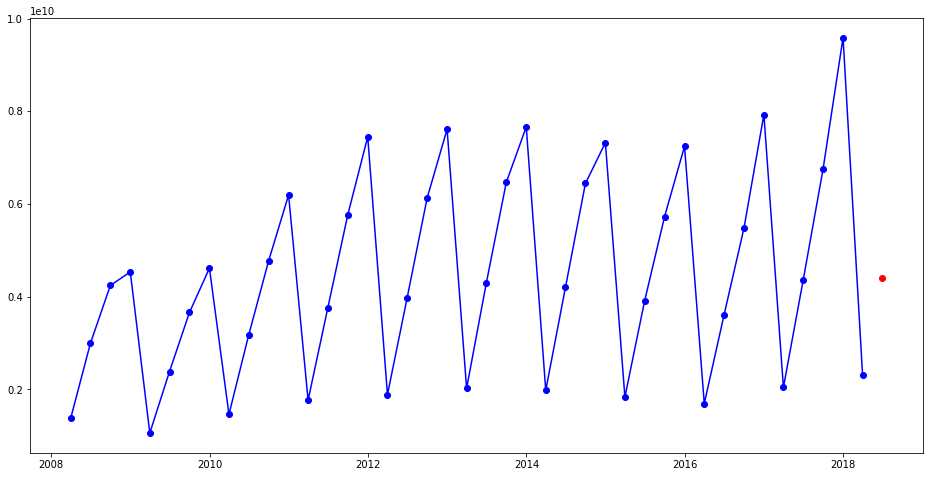

In [271]:
#全市场营收平均值的时间序列图以及二季度营收的预测值
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).mean(),'bo-')
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock['REVENUE'].mean(),'ro')